In [177]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as rnd
import random
import math
import copy
import seaborn as sns

## 0. Parameters settings

In [178]:
num_pop = 100
dimension = 2
size = 10 #(-100<= X <=100 by binary)

crossover_prob = 0 # 0.7, 0.8, 0.9
mutation_prob = 0.01 # 0.01, 0.03, 0.05

function_selected = "Sphere" #Sphere #Rastrigin 

## 1. Functions

### 1.1. About chromosomes

In [179]:
"""
Generate random solution
"""
def generate_random_solution(size):
    solution = []
    chromosome = []
    sign = []
    
    # Chromosome
    current_size = 0
    while current_size < size:
        chromosome.append(random.randint(0,1))
        current_size = current_size + 1
    
    # Sign + -
    sign_candidate = [-1, 1]
    sign.append(random.choice(sign_candidate))

    # Merge solution
    solution.append(chromosome)
    solution.append(sign)
    # print(solution)

    return solution

"""
Chromosome genotype solution value function
"""

def chromosome_bin_to_decimal(chromosome): 
    #
    power = 6
    sum = 0
    # print(f'power: {power}')
    #
    for idx in range(0,len(chromosome[0])):
        # print((chromosome[0][idx]) * (2**power))
        sum = sum + (chromosome[0][idx]) * (2**power)
        power = power - 1
    
    
    return sum * chromosome[1][0]


### 1.2. Objective functions

In [180]:
"""
Sphere function(objective)
input: decimal
"""
def Sphere_function(x):
    return x**2

def Rastrigin_function(x):
    return (x**2 - 10 * math.cos(2*(math.pi)*x) + 10)


In [181]:
"""
Calculate objective function and judge the best solution
"""

def calculate_objective_function(solution_set):

    value_set = []
    for sol_idx in range(0, len(solution_set)):
        
        sum = 0
        if function_selected == 'Sphere':    
            for dim in range(0,dimension):
                sum = sum + Sphere_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
            
        elif function_selected == 'Rastrigin':    
            for dim in range(0,dimension):
                sum = sum + Rastrigin_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
        else:
            print("PLEASE SET YOUR FUNCTION")

    # print(value_set)
    
    return value_set

### 1.3. About selection

In [182]:
"""
Calculate objective function and compose selection probability (1st: 50%, 2nd: 25%, 3rd: 12.5% ...)
"""

def calculate_obj_and_compose_selection_probability(solution_set):

    value_set = calculate_objective_function(solution_set)
    
    # Ascending
    temp_df = pd.DataFrame({"index":(range(0,num_pop)), "obj.val": value_set})
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    increasing_index = temp_df['index'].values.tolist()
       
    #
    selection_prob = [-999 for i in range(0,num_pop)]
    sum1_idx = 0
    for count in range(0,(num_pop-1)):
        #
        # print(f'{count}: {increasing_index}')
        where_point = increasing_index.index(count)
        selection_prob[where_point] = 0.5*(0.5)**(count)
        sum1_idx = sum1_idx + 0.5*(0.5)**(count)
    
    where_point = increasing_index.index(num_pop-1)
    selection_prob[where_point] = 1 - sum1_idx
    
    # print(f'selection_prob: {selection_prob}')
            
    return selection_prob



In [183]:
"""
Calculate objective function and compose selection probability based on reciprocal of fitness values
"""
def calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set):
    
    value_set = calculate_objective_function(solution_set)
    # print(value_set)
    
    # Reciprocal
    value_recip_set = []
    for v in value_set:
        if v == 0:
            value_recip_set.append(0)
        else:
            value_recip_set.append(1/v)
    
    denom = np.sum(value_recip_set)
    selection_prob = []
    for i in value_recip_set:
        selection_prob.append(i/denom)
    
            
    return selection_prob

### 1.4. Crossver and Mutation

In [184]:
"""
One-point crossover
: between same dimension

"""
def execute_crossover_standard(solution_1, solution_2):
    
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)
    # print(f'solution tmp: {solution_1_tmp}, {solution_2_tmp}')
    # Crossover
    dim = 0
    while dim < dimension:
        
        # Save current solutions
        current_sol1 = solution_1_tmp[dim][0]
        current_sol2 = solution_2_tmp[dim][0]
        # print(f'{current_sol1}\n{current_sol2}')
        
        # Copy the new solution from the current solutions
        new_sol1 = copy.deepcopy(current_sol1)
        new_sol2 = copy.deepcopy(current_sol2)
        
        # Find location for one-point crossover
        point_loc = random.randint(1,(len(current_sol1)-2))
        
        # print(f'len: {(len(current_sol1)-1)}')
        
        # print(f'point_loc: {point_loc}')
        
        for loc_idx in range(0, point_loc):
            new_sol1[loc_idx] = current_sol2[loc_idx]
            new_sol2[loc_idx] = current_sol1[loc_idx]
        
        solution_1_tmp[dim][0] = new_sol1
        solution_2_tmp[dim][0] = new_sol2
        
        # Update
        dim = dim + 1

    # print(f'{solution_1_tmp}\n{solution_2_tmp}')
    return solution_1_tmp, solution_2_tmp

"""
Modified crossover: crop & merge
"""
def execute_crossover_modified(solution_1, solution_2):
        
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)
    # print(f'solution tmp: {solution_1_tmp}, {solution_2_tmp}')
    # Crossover
    dim = 0
    while dim < dimension:
        
        # Save current solutions
        current_sol1 = solution_1_tmp[dim][0]
        current_sol2 = solution_2_tmp[dim][0]
        # print(f'{current_sol1}\n{current_sol2}')
        
        # Copy the new solution from the current solutions
        new_sol1 = copy.deepcopy(current_sol1)
        new_sol2 = copy.deepcopy(current_sol2)
                
        # CROP: Find locations for crop in consecutive numbers (0~5) 
        crop_loc = random.randint(0,(len(current_sol1)-2))
        # print(f'crop_loc: {crop_loc}')
        
        # MERGE: Find two locations for merge (7C2)
        merge_loc = list(range(len(current_sol1)))
        merge_list = random.sample(merge_loc, 2)
        # print(f'merge_list: {merge_list}')
        
        #
        new_sol1[crop_loc] = current_sol2[merge_list[0]]
        new_sol1[crop_loc+1] = current_sol2[merge_list[1]]
        
        new_sol2[merge_list[0]] = current_sol1[crop_loc]
        new_sol2[merge_list[1]] = current_sol1[crop_loc+1]   
                
        solution_1_tmp[dim][0] = new_sol1
        solution_2_tmp[dim][0] = new_sol2
                
        # Update
        dim = dim + 1

    # print(f'{solution_1_tmp}\n{solution_2_tmp}')
    return solution_1_tmp, solution_2_tmp


In [185]:
"""
Standard mutation
: select only one
"""
def execute_mutation_standard(new_solution_1, new_solution_2):

    remember_signal = -99
    # Select
    if random.random() <= 0.5:
        mutation_target_chromosome = copy.deepcopy(new_solution_1)
        remember_signal = 1
    else:
        mutation_target_chromosome = copy.deepcopy(new_solution_2)
        remember_signal = 2
        
    # print("!: ",remember_signal)

    # Choose the location randomly along all dimension 
    dim = 0
    while dim < dimension:
        temp_chromosome = mutation_target_chromosome[dim][0]
        # print(temp_chromosome)
        
        point_loc = random.randint(0,(len(temp_chromosome)-1))
        
        # print(f'{point_loc}: {temp_chromosome[point_loc]}')
        
        if temp_chromosome[point_loc] == 0:
            temp_chromosome[point_loc] = 1
        else:
            temp_chromosome[point_loc] = 0
            
        # print(temp_chromosome)
        # print("\n")
        dim = dim + 1

    if remember_signal == 1:
        new_solution_1 = copy.deepcopy(mutation_target_chromosome)
    elif remember_signal == 2:
        new_solution_2 = copy.deepcopy(mutation_target_chromosome)
    else:
        print("error")
        
    return new_solution_1, new_solution_2

"""
Modified mutation
: select 1~3
"""
def execute_mutation_modified(new_solution_1, new_solution_2):
    remember_signal = -99
    # Select
    if random.random() <= 0.5:
        mutation_target_chromosome = copy.deepcopy(new_solution_1)
        remember_signal = 1
    else:
        mutation_target_chromosome = copy.deepcopy(new_solution_2)
        remember_signal = 2
        
    # print("!: ",remember_signal)

    # Choose the location randomly along all dimension 
    dim = 0
    while dim < dimension:
        temp_chromosome = mutation_target_chromosome[dim][0]
        # print(temp_chromosome)
        
        point_loc_list = []
        point_loc_origin = random.randint(0,(len(temp_chromosome)-1))
        point_loc_list.append(point_loc_origin)
        
        # print(f'point_loc: {point_loc_origin}')
        #
        if point_loc_origin == 0:
            if random.random() <= 0.5:
                point_loc_list.append(point_loc_origin+1)
            
        elif point_loc_origin == (len(temp_chromosome)-1):
            if random.random() <= 0.5:
                point_loc_list.append(point_loc_origin-1)
        else:
            if random.random() <= 0.5:
                point_loc_list.append(point_loc_origin-1)
            if random.random() <= 0.5:
                point_loc_list.append(point_loc_origin+1)
        
        # print(f'point_loc_list: {point_loc_list}')
        
        
        for mut_loc in point_loc_list:
            
            # print(f'{mut_loc}: {temp_chromosome[mut_loc]}')
            
            if temp_chromosome[mut_loc] == 0:
                temp_chromosome[mut_loc] = 1
            else:
                temp_chromosome[mut_loc] = 0
                
        # print(temp_chromosome)
        # print("\n")
        dim = dim + 1

    if remember_signal == 1:
        new_solution_1 = copy.deepcopy(mutation_target_chromosome)
    elif remember_signal == 2:
        new_solution_2 = copy.deepcopy(mutation_target_chromosome)
    else:
        print("error")
        
    return new_solution_1, new_solution_2

## 2. Generate initial population
[[0, 0, 1, 0, 0, 0, 0], [sign]]

In [186]:
"""
Example of chromosome
"""
chromosome = generate_random_solution(size)
val = chromosome_bin_to_decimal(chromosome)

print(chromosome)
print(val)

[[1, 1, 1, 0, 0, 0, 0, 1, 1, 0], [1]]
112.75


In [187]:
"""
Generate intial population
"""
solution_set = []

successful_pop = 1
while successful_pop <= num_pop:
    
    # Generate    
    temp_solution_set = []
    success_dim = 0
    while success_dim < dimension:
        temp_chromosome = generate_random_solution(size)
        val = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution: -100 ~ +100
        if (val >= -100) &  (val <= 100):
            temp_solution_set.append(temp_chromosome)
            success_dim = success_dim + 1
        else:
            pass
            # print(f'Infeasible!...')
    # Append
    solution_set.append(temp_solution_set)
    # print(f'Generated num of population: {successful_pop}')
    
    # Update
    successful_pop = successful_pop + 1
    
# OUTPUT: solution_set

In [188]:
# for i in range(0, len(solution_set)):
    
#     print(solution_set[i])

## 3. Roulette-wheel selection

In [189]:
"""
Set the roulette-wheel and select two individual solutions
"""
obj_list = calculate_objective_function(solution_set)
print(obj_list)

# selection probability based on fitness values
selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
print(selection_prob)


# select only two chromosomes within 1~Npop
num_list = list(range(0,(num_pop)))
print(num_list)


selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
print(selected_pop)


[6120.90625, 1124.453125, 7011.53125, 1164.25, 12225.953125, 8775.3125, 10554.765625, 3998.453125, 1679.3125, 13495.15625, 9879.828125, 9847.65625, 6650.453125, 471.25, 12767.765625, 3998.828125, 10708.890625, 7255.8125, 10053.25, 15805.65625, 8970.8125, 11500.25, 3872.8125, 11705.265625, 11419.65625, 5530.015625, 898.328125, 9724.0625, 5317.0625, 14223.15625, 1530.953125, 13069.703125, 2612.453125, 696.640625, 8077.65625, 3388.578125, 11164.328125, 11813.125, 751.5625, 12099.90625, 6111.625, 2568.90625, 8612.5, 7748.890625, 7889.640625, 2393.265625, 8175.390625, 1734.53125, 10407.8125, 5591.5625, 824.078125, 16896.078125, 277.625, 12936.640625, 13653.78125, 4453.0625, 7708.703125, 10966.515625, 10758.5, 3739.78125, 5890.625, 1570.28125, 5712.203125, 19751.5625, 12242.265625, 7666.015625, 9315.125, 4742.140625, 5721.765625, 1397.640625, 9854.078125, 9608.890625, 9343.953125, 12374.453125, 4584.53125, 5532.03125, 4817.125, 8201.328125, 7091.140625, 7455.828125, 2206.140625, 3784.890625,

## 4. Crossover

In [190]:
"""
Execute crossover with crossover probability: select only two
"""
# Selected two solutions
solution_1 = solution_set[selected_pop[0]]
solution_2 = solution_set[selected_pop[1]]
print(f'current\n{solution_1}\n{solution_2}')

if random.random() <= crossover_prob:
    new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
    print(f'new\n{new_solution_1}\n{new_solution_2}')


current
[[[0, 0, 0, 0, 1, 1, 0, 0, 1, 0], [-1]], [[0, 1, 0, 1, 0, 0, 0, 1, 0, 0], [-1]]]
[[[0, 0, 1, 1, 0, 1, 1, 0, 1, 1], [1]], [[1, 0, 1, 0, 1, 0, 0, 1, 0, 0], [1]]]


## 5. Mutation

In [191]:
"""
Execute muatation with crossover probability: select only one solution between two solutions
"""

# print(f'current\n{new_solution_1}\n{new_solution_2}')
# if random.random() <= mutation_prob: # mutation_prob
#     new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
#     print(f'new\n{new_solution_1}\n{new_solution_2}')

'\nExecute muatation with crossover probability: select only one solution between two solutions\n'

## 6. Alternate

In [192]:
"""
Alternative I
"""
def alternative_1(solution_set, new_solution_1, new_solution_2):
   
    solution_set[selected_pop[0]] = new_solution_1
    solution_set[selected_pop[1]] = new_solution_2
    
    return solution_set

In [193]:
"""
Alternative II
"""
def alternative_2(solution_set, new_solution_1, new_solution_2):
    alt2_solution_set = copy.deepcopy(solution_set)
    alt2_obj_set = copy.deepcopy(calculate_objective_function(solution_set))

    
    if function_selected == 'Sphere':
        # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Sphere_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Sphere_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    elif function_selected == 'Rastrigin':
            # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    else:
        print("PLEASE SET YOUR FUNCTION!")

    # Remove twice
    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+2)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+1)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    # print(alt2_obj_set)
    

    # Replace solution_set with alt2_solution_set
    return alt2_solution_set

## 7. Indicator plot(operators analysis)

In [194]:
"""
Take coordinates under dimension
"""
def take_coordinates(solution_set):
    
    x_set = []
    for sol_idx in range(0, len(solution_set)):
        
        x_tmp = []
        for dim in range(0,dimension):
            x_tmp.append(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
        x_set.append(x_tmp)

    return x_set
        
    # return value_set

In [195]:
"""
Exploration
: standard deviation
"""
def exploration_indicator(solution_set):
    
    # print(solution_set)
    plot_for_indicators = take_coordinates(solution_set)
    
    x1_list = []
    x2_list = []
    for i in plot_for_indicators:
        x1_list.append(i[0])
        x2_list.append(i[1])
    
     # np.var(x1_list)
    sum1 = 0
    for x1 in x1_list:
        sum1 = sum1 + (x1-0)**2
    sum2 = 0
    for x2 in x2_list:
        sum2 = sum2 + (x2-0)**2

    #
    # print(f'Exploration indicator: {round((s1+s2)/2, 2)}')
    return ((sum1/num_pop)+(sum2/num_pop))/2

"""
Exploitation
: (current area) / (initial area)
"""
def exploitation_indicator(solution_set):
    
    # print(solution_set)
    plot_for_indicators = take_coordinates(solution_set)
    
    # Archery target
    sum = 0
    for coordinate in plot_for_indicators:
        point = ((coordinate[0])**2 + (coordinate[1])**2)**0.5
        
        # print(f'point: {point}')
        # print(f'sum: {sum}')
        if point == 0:
            sum = sum + 0
        elif point <= 1:
            sum = sum + 0.01
        elif point <= 2:
            sum = sum + 0.02
        elif point <= 3:
            sum = sum + 0.03
        elif point <= 4:
            sum = sum + 0.04
        elif point <= 5:
            sum = sum + 0.05
        elif point <= 6:
            sum = sum + 0.06
        elif point <= 7:
            sum = sum + 0.07
        elif point <= 8:
            sum = sum + 0.08
        elif point <= 9:
            sum = sum + 0.09
        elif point <= 10:
            sum = sum + 0.1
        else:
            sum = sum + 1
    
    if sum == 0:
        sum = float('inf')
    else:
        sum = 1/sum
    
    return sum
    
"""
Basis plot
"""
def basis_plot(solution_set, iteration):
    # Indicators
    exploration_ind = round(exploration_indicator(solution_set),2)
    exploitation_ind = round(exploitation_indicator(solution_set),2)
    
    # Minimum value
    min_val = round(min(calculate_objective_function(solution_set)),2)
    
    
    # 
    plot_for_indicators = take_coordinates(solution_set)    
    x, y = zip(*plot_for_indicators)
    
    plt.scatter(x,y, s=12, color='black')
    plt.scatter(0,0, s=12, color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([-120, 120])      # X축의 범위: [xmin, xmax]
    plt.ylim([-120, 120]) 
    plt.title(f':::{function_selected}:::  Iteration: {iteration}, Crossover_prob: {crossover_prob}, Mutation_prob: {mutation_prob}\nmin: {min_val}, Exploration: {exploration_ind}, Exploitation: {exploitation_ind}')
    plt.show()

    print(f'plot_for_indicators: {plot_for_indicators}')
    # print(f'minimum value: {min(calculate_objective_function(solution_set))}')
    


## @@ Iteration test @@

In [196]:
MAX_ITR = 10000

In [197]:
print(f'::: {function_selected} ::: Crossover_prob: {crossover_prob}, Mutation_prob: {mutation_prob} ::: Modified :::') # Standard, modified
total_solution_list = []
total_exploration_list = []
total_exploitation_list = []

running = 1
while running <= 100:
    
    """
    Generate intial population
    """

    list_for_plot = []
    temp_exploration_list = []
    temp_exploitation_list = []

    #
    solution_set = []
    successful_pop = 1
    while successful_pop <= num_pop:
        
        # Generate    
        temp_solution_set = []
        success_dim = 0
        while success_dim < dimension:
            temp_chromosome = generate_random_solution(size)
            val = chromosome_bin_to_decimal(temp_chromosome)
        
            # for the warm initial solution: -100 ~ +100
            if (val >= -100) &  (val <= 100):
                temp_solution_set.append(temp_chromosome)
                success_dim = success_dim + 1
            else:
                pass
                # print(f'Infeasible!...')
        # Append
        solution_set.append(temp_solution_set)
        # print(f'Generated num of population: {successful_pop}')
        
        # Update
        successful_pop = successful_pop + 1

    iteration = 0
    # basis_plot(solution_set, iteration)

    list_for_plot.append(min(calculate_objective_function(solution_set)))


    iteration = 1
    while iteration <= MAX_ITR:

        """
        Set the roulette-wheel and select two individual solutions
        """

        # selection probability based on fitness values
        
        selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
        # selection_prob = calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set)

        # 1~Npop
        num_list = list(range(0,num_pop))
        # selected_pop
        selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
        # print(selected_pop)

        """
        Execute crossover with crossover probability: select only two
        """
        # Selected two solutions
        solution_1 = solution_set[selected_pop[0]]
        solution_2 = solution_set[selected_pop[1]]
        # print(f'current\n{solution_1}\n{solution_2}')

        if random.random() <= crossover_prob:
            
            # new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
            new_solution_1, new_solution_2 = execute_crossover_modified(solution_1, solution_2)
            
            # print(f'new\n{new_solution_1}\n{new_solution_2}')
        else:
            new_solution_1 = copy.deepcopy(solution_1)
            new_solution_2 = copy.deepcopy(solution_2)
        """
        Execute muatation with crossover probability: select only one solution between two solutions
        """

        # print(f'current\n{new_solution_1}\n{new_solution_2}')
        if random.random() <= mutation_prob: # mutation_prob
            
            # new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
            new_solution_1, new_solution_2 = execute_mutation_modified(new_solution_1, new_solution_2)
            # print(f'current\n{new_solution_1}\n{new_solution_2}')
        else:
            new_solution_1 = copy.deepcopy(solution_1)
            new_solution_2 = copy.deepcopy(solution_2)    


        """
        Alternative I or II
        """
        solution_set = alternative_2(solution_set, new_solution_1, new_solution_2)    
        
        
        """
        Evaluation
        """
        iterative_solution_set = calculate_objective_function(solution_set)
        
        # print(f'{iteration} | Best solution {solution_set[iterative_solution_set.index(min(iterative_solution_set))]}, value: {min(iterative_solution_set)}, index: {iterative_solution_set.index(min(iterative_solution_set))}')
        list_for_plot.append(min(iterative_solution_set))
        
        """
        Basis plot
        """
        if iteration%1000 == 0:
            temp_exploration_list.append(exploration_indicator(solution_set))
            temp_exploitation_list.append(exploitation_indicator(solution_set))
            
        
        # Update
        iteration = iteration + 1
    
    #    
    total_solution_list.append(min(list_for_plot))
    total_exploration_list.append(temp_exploration_list)
    total_exploitation_list.append(temp_exploitation_list)
    
    print(f'running: {running}  Completed! | min: {min(list_for_plot)} | {temp_exploration_list} | {temp_exploitation_list}')
    running = running + 1
    


::: Sphere ::: Crossover_prob: 0, Mutation_prob: 0.01 ::: Modified :::


running: 1  Completed! | min: 0.125 | [80.3125, 80.27999999999999, 80.26890625, 78.591953125, 77.709140625, 76.931640625, 76.931640625, 76.39703125000001, 76.39703125000001, 76.12703125] | [0.01, 0.01, 0.01, 0.01019367991845056, 0.010297600659046441, 0.010401497815685458, 0.010401497815685458, 0.010500892575868948, 0.010500892575868948, 0.010500892575868948]
running: 2  Completed! | min: 6.765625 | [17.835625, 17.51546875, 17.491875, 17.391640625, 17.263515625, 17.253671875000002, 17.03125, 17.03125, 8.544375, 5.061171875] | [0.16694490818030078, 0.16835016835016858, 0.16835016835016858, 0.16863406408094458, 0.16920473773265673, 0.16920473773265673, 0.16949152542372903, 0.16949152542372903, 0.2123142250530788, 0.2506265664160399]
running: 3  Completed! | min: 3.828125 | [70.800625, 70.398359375, 70.0996875, 69.304765625, 68.44609374999999, 67.85593750000001, 67.736328125, 9.265625, 9.157265624999999, 9.157265624999999] | [0.01, 0.010091835704914724, 0.010184336490477645, 0.010283833813

In [198]:
print(f'::: {function_selected} ::: Crossover_prob: {crossover_prob}, Mutation_prob: {mutation_prob} ::: Modified :::') # Standard, modified

total_solution_df = pd.DataFrame(total_solution_list)
total_exploration_df = pd.DataFrame(total_exploration_list)
total_exploitation_df = pd.DataFrame(total_exploitation_list)

total_solution_df.to_csv(f"C:/Users/TLSYSLAB_3_ADMIN/Documents/Git/TIL_1hour/GENETIC_ALGORITHM/result/solution_{function_selected}_Modified_C{crossover_prob}_M{mutation_prob}.csv")
total_exploration_df.to_csv(f"C:/Users/TLSYSLAB_3_ADMIN/Documents/Git/TIL_1hour/GENETIC_ALGORITHM/result/exploration_{function_selected}_Modified_C{crossover_prob}_M{mutation_prob}.csv")
total_exploitation_df.to_csv(f"C:/Users/TLSYSLAB_3_ADMIN/Documents/Git/TIL_1hour/GENETIC_ALGORITHM/result/exploitation_{function_selected}_Modified_C{crossover_prob}_M{mutation_prob}.csv")


::: Sphere ::: Crossover_prob: 0, Mutation_prob: 0.01 ::: Modified :::


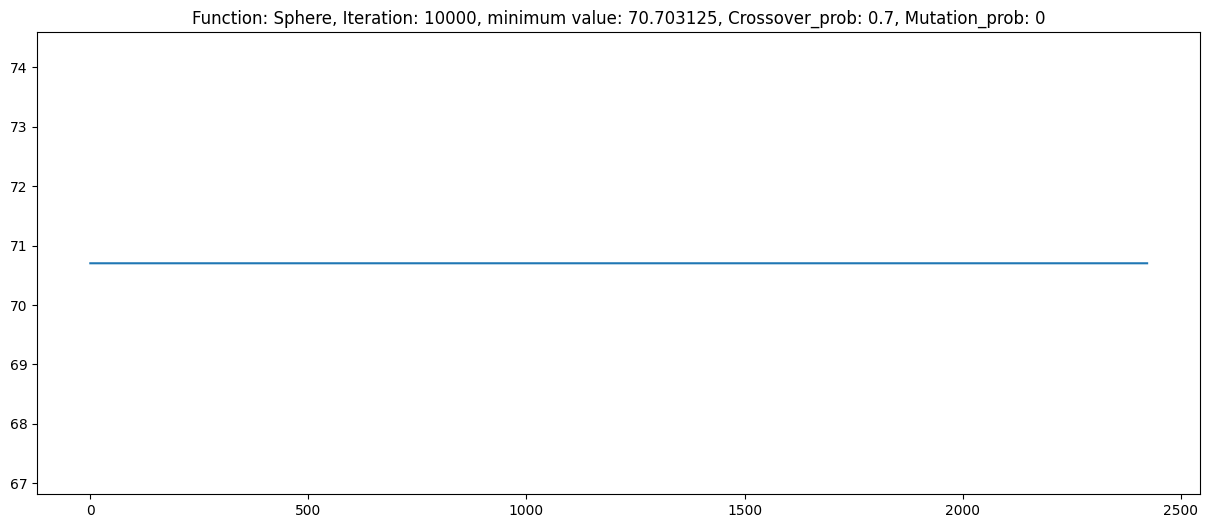

In [79]:
plt.figure(figsize=(15,6))
plt.plot(list_for_plot)
plt.title(f'Function: {function_selected}, Iteration: {MAX_ITR}, minimum value: {min(list_for_plot)}, Crossover_prob: {crossover_prob}, Mutation_prob: {mutation_prob}')
plt.show()

In [552]:
"""
Develop indicators(Exploration/Exploitation)
"""

'\nDevelop indicators(Exploration/Exploitation)\n'

## Dev note
- 전반적으로 오류나는거 체크(len 범위 착각)
- selection 할때 1, 2등에 거의 몰빵해야 함 예) 50*(1/2)**(r-100)
- Update하고 나서 feasibility 체크 따로 안 해도 될까?